In [150]:
import re
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import math
import os
from bokeh.plotting import figure, output_file, show
from bokeh.models import Range1d
from bokeh.embed import components

In [5]:
%matplotlib inline

In [6]:
def get_filename_components(filename):
    frase = r"(?<=ictcp_out_).+(?=_)"
    match = re.findall(frase, filename)
    algo, target, tools, opt = match[0].split("_")
    tools = tools.split("-")
    return algo, target, tools[0], tools[1], opt

In [7]:
def get_ictcp_values(filepath, filename):
    frame = []
    min_deltaE = []
    max_deltaE = []
    ave_deltaE = []
    gmax_deltaE = []
    gave_deltaE = []
    match1 = r"frame "
    match2 = r"\{ min "
    match3 = r" max "
    match4 = r" ave "
    match5 = r"Global average \= "
    match6 = r"maximum \= "
    
    read_log = open(filepath + filename)
    for txt_line in read_log:
        frame_found = re.findall(r"(?<={})\d+".format(match1), txt_line)
        min_deltaE_found = re.findall(r"(?<={})\d+\.\d+\D+?\d+".format(match2), txt_line)
        max_deltaE_found = re.findall(r"(?<={})\d+\.\d+\D+?\d+".format(match3), txt_line)
        ave_deltaE_found = re.findall(r"(?<={})\d+\.\d+\D+?\d+".format(match4), txt_line)
        gmax_deltaE_found = re.findall(r"(?<={})\d+\.\d+\D+?\d+".format(match5), txt_line)
        gave_deltaE_found = re.findall(r"(?<={})\d+\.\d+\D+?\d+".format(match6), txt_line)
        [frame.append(f) for f in frame_found if len(frame_found) > 0]
        [min_deltaE.append(mind) for mind in min_deltaE_found if len(min_deltaE_found) > 0]
        [max_deltaE.append(maxd) for maxd in max_deltaE_found if len(max_deltaE_found) > 0]
        [ave_deltaE.append(ave) for ave in ave_deltaE_found if len(ave_deltaE_found) > 0]
        [gmax_deltaE.append(gmax) for gmax in gmax_deltaE_found if len(gmax_deltaE_found) > 0]
        [gave_deltaE.append(gave) for gave in gave_deltaE_found if len(gave_deltaE_found) > 0]
    read_log.close()
    return frame, min_deltaE, max_deltaE, ave_deltaE, gmax_deltaE, gave_deltaE

### This function (draw_ictcp) contains the main functionality and calls the two previoues functions:

In [167]:
def draw_ictcp(file, inpath, outpath):
    algo, target, tools1, tools2, opt = get_filename_components(file)
    frame, min_deltaE, max_deltaE, ave_deltaE, gmax_deltaE, gave_deltaE = get_ictcp_values(inpath, file)
    name = "_".join((tools1, tools2, algo, target, opt))
    index = ['Source1', 'Source2', 'DM Algo', 'Target', 'Frame', 
             'Delta ICTCP min', 'Delta ICTCP max', 'Delta ICTCP ave',
             'Delta ICTCP Global max', 'Delta ICTCP Global average']
    content = []
    for f in range(0, len(frame), 1):
        temp = [tools1, tools2, algo, target, frame[f], 
                min_deltaE[f], max_deltaE[f], ave_deltaE[f], 
                gmax_deltaE[0], gave_deltaE[0]]
        content.append(temp)
        
    if len(frame) == len(min_deltaE) == len(max_deltaE) == len(ave_deltaE) and len(gmax_deltaE) == len(gave_deltaE) == 1:
        print("Reading --> " + name)
    else:
        print("Date extraction not possible! \n Please check log file format.")
    # data prep
    df = pd.DataFrame(list(np.array(content).T), index=index)
    l_dict = {'t1': '100', 't27': '600', 't49': '1000'}
    nr_frame = int(df.columns[-1])
    x = range(len(df.columns))
    show_value = 'Delta ICTCP max'
    y_max = [float(y) for y in df.loc['Delta ICTCP max']]
    y_avg = [float(y) for y in df.loc['Delta ICTCP ave']]
    y_th02 = [0.2 for i in range(0, int(len(x)))]
    y_th10 = [1 for i in range(0, int(len(x)))]                           
    max_yticks = math.ceil(max(y_max))
    if max_yticks < 2:
        max_yticks = 2
    # draw matplotlib plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_max, 'b.', label = 'Delta ICTCP max')
    plt.plot(x, y_avg, 'c.', label = 'Delta ICTCP ave')
    plt.plot(range(0,nr_frame), [0.2,]*nr_frame, 'g', label = 'Threshold of 0.2 JND', linestyle='dotted')
    plt.plot(range(0,nr_frame), [1,]*nr_frame, 'r', label = 'Threshold of 1 JND', linestyle='dotted')
    plt.yticks(range(0, max_yticks, math.ceil(max_yticks/10)))
    plt.xticks(range(0, 155, 20))
    plt.xlabel('number of frames')
    plt.ylabel('Delta ICTCP error level')
    title = f'Target {target[1:]} - {l_dict[target]}nits image quality comparison of {tools1} {opt} vs. {tools2} {str.upper(algo)} modul'
    plt.title(title)
    plt.legend()
    plt.savefig(outpath + file.split('.')[0] + ".png", dpi=200)
    
    # prep bokeh plot & output to static HTML file
    # TODO output HTML only if DATA not NULL
    output_file(outpath + file.split('.')[0] + ".html")
    tools = ["pan","box_zoom","hover","reset","save"]
    TOOLTIPS = [
        ("Frame", "$index"),
        ("JND", "$y")
    ]
    p = figure(
        tools=tools, tooltips=TOOLTIPS, toolbar_location="above",
        y_range=[0, max_yticks], title=title,
        x_axis_label='Number of frames', y_axis_label='Delta ICTCP error level in JND',
        plot_width=1000, plot_height=500)
    # add bokeh renderers for each graph (y value)
    p.line(x, y_th02, legend_label='Threshold of 0.2 JND', line_color="green", line_dash="4 4", line_width=2, alpha=0.5)
    p.line(x, y_th10, legend_label='Threshold of 1 JND', line_color="red", line_dash="4 4", line_width=2, alpha=0.5)
    p.line(x, y_max, legend_label='Delta ICTCP max')
    p.circle(x, y_max, legend_label='Delta ICTCP max', fill_color="white", fill_alpha=0.4, size=8)
    p.line(x, y_avg, legend_label='Delta ICTCP average', line_color="orange")
    p.circle(x, y_avg, legend_label='Delta ICTCP average', fill_color="white", fill_alpha=0.4, line_color="orange", size=8)
    # show the results
    show(p)

### prep files for processing:

In [168]:
# enter path containing logfiles here:
mainpath = "/Users/hquos/Projects/DSV_libdm4/logs/01_DvDmApp/ictcp/"

In [169]:
main_content = glob.glob(mainpath + "**/")
subdirs = [dirpath.split("/") for dirpath in main_content]
cases = [subdir[-2] for subdir in subdirs]
cases_path = [mainpath+c for c in cases]

[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/092541000/'
Processing --> 092541000
Reading --> BER_SUN_dm4_t49_no-opt
Reading --> BER_SUN_dm4_t27_opt-avx2
Reading --> BER_SUN_dm4_t49_opt-avx2
Reading --> BER_SUN_dm3_t1_no-opt
Reading --> BER_SUN_dm4_t1_opt-avx2
Reading --> BER_SUN_dm4_t1_no-opt
Reading --> BER_SUN_dm4_t27_no-opt
Reading --> BER_SUN_dm3_t27_opt-avx2
Reading --> BER_SUN_dm3_t49_opt-avx2
Reading --> BER_SUN_dm3_t27_no-opt
[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/030/'
Processing --> 030
Reading --> BER_SUN_dm4_t49_no-opt
Reading --> BER_SUN_dm3_t1_opt-avx2
Reading --> BER_SUN_dm3_t49_no-opt
Reading --> BER_SUN_dm4_t27_opt-avx2
Reading --> BER_SUN_dm4_t49_opt-avx2
Reading --> BER_SUN_dm3_t1_no-opt
Reading --> BER_SUN_dm4_t1_opt-avx2
Reading --> BER_SUN_dm4_t1_no-opt
Reading --> BER_SUN_dm4_t27_no-opt
Reading --> BER_SUN_dm3_t27_opt-avx2
Reading --> BER_SUN_dm3_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/092541003/'
Processing --> 092541003
Reading --> BER_SUN_dm4_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/092541033/'
Processing --> 092541033
Reading --> BER_SUN_dm4_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/092541081/'
Processing --> 092541081
Reading --> BER_SUN_dm4_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


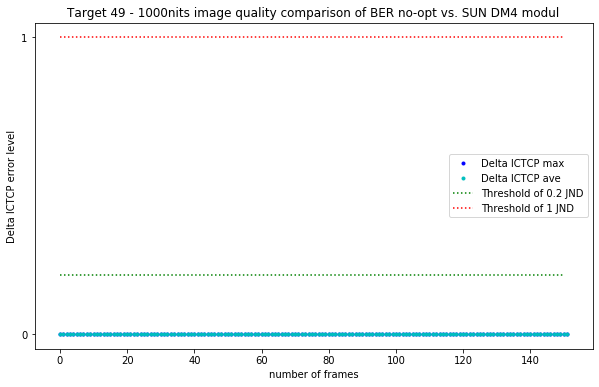

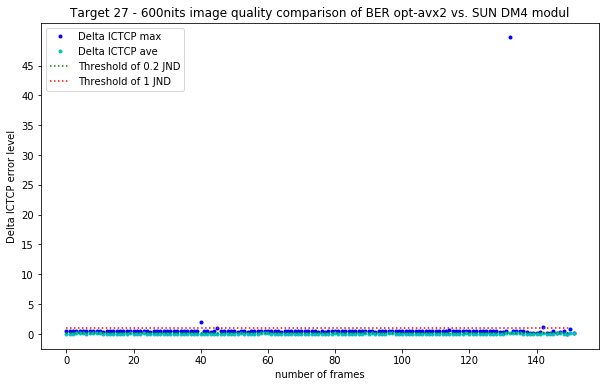

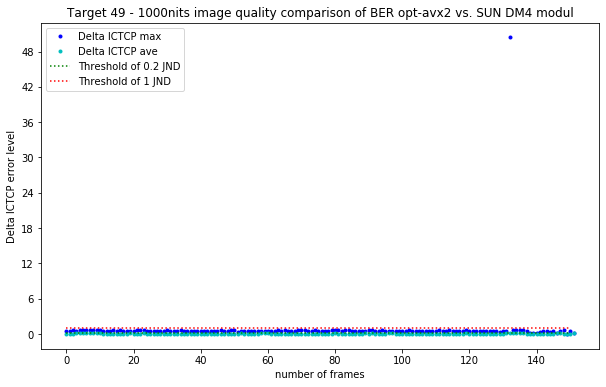

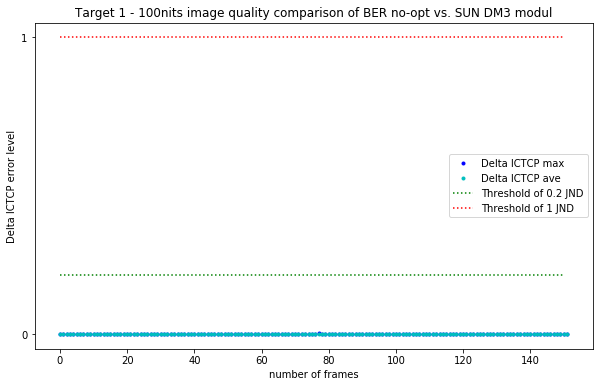

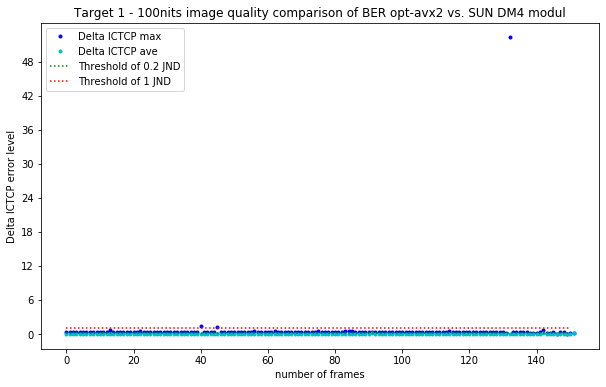

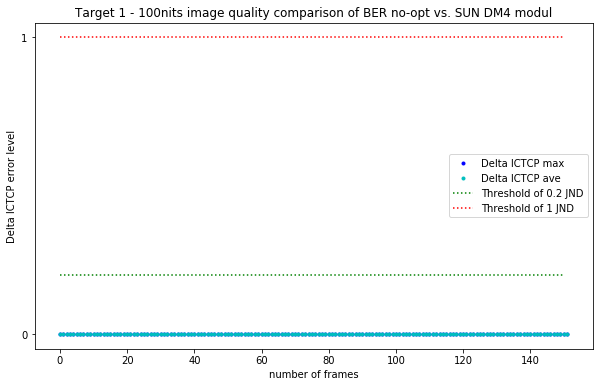

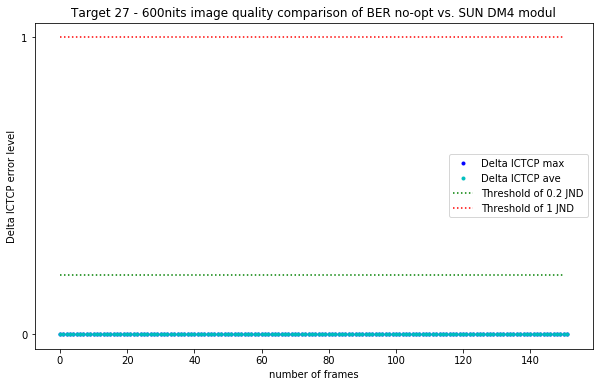

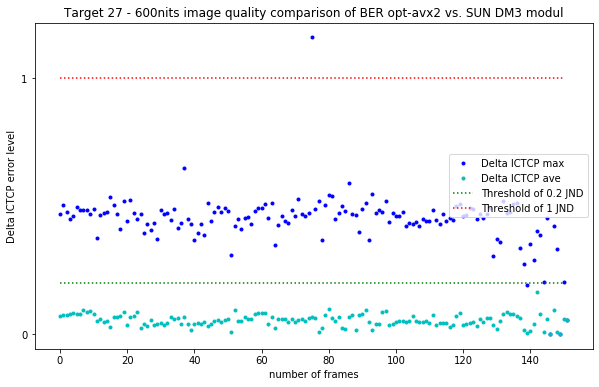

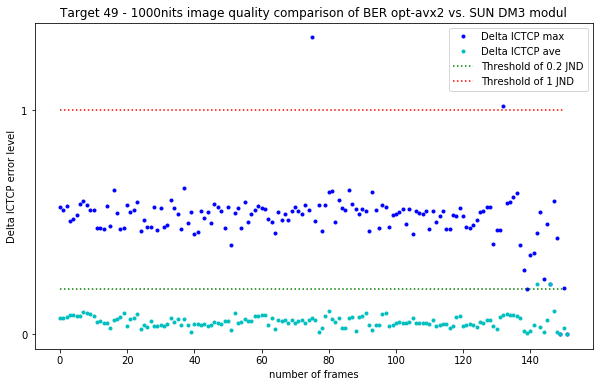

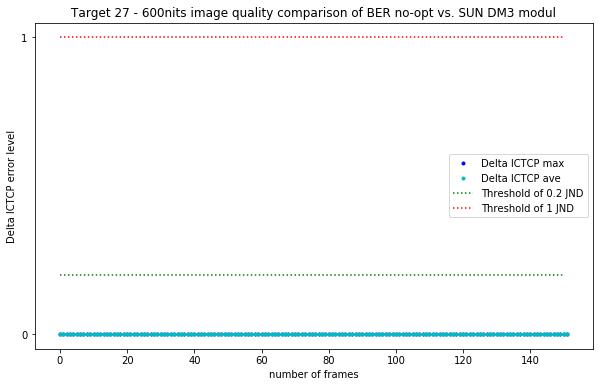

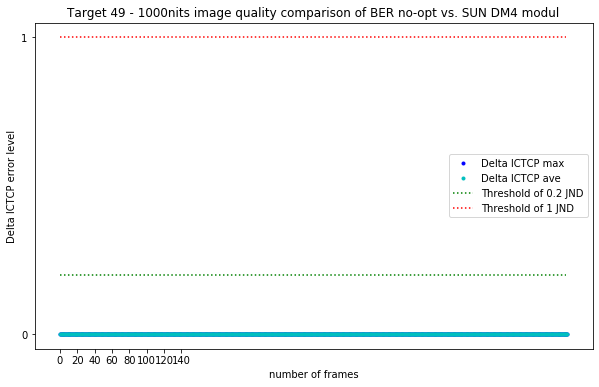

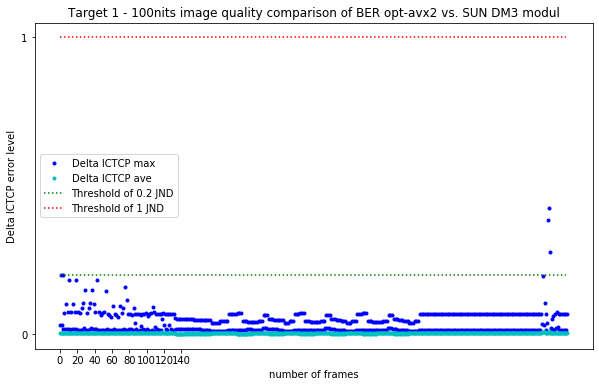

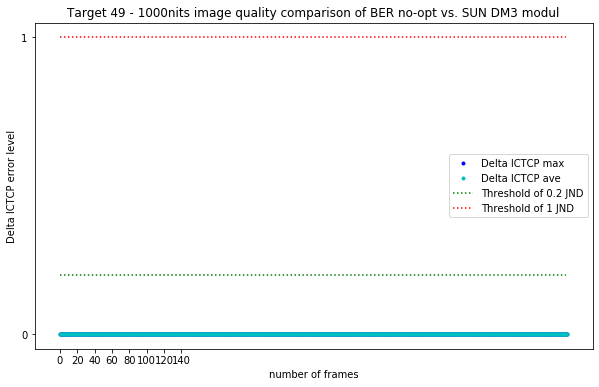

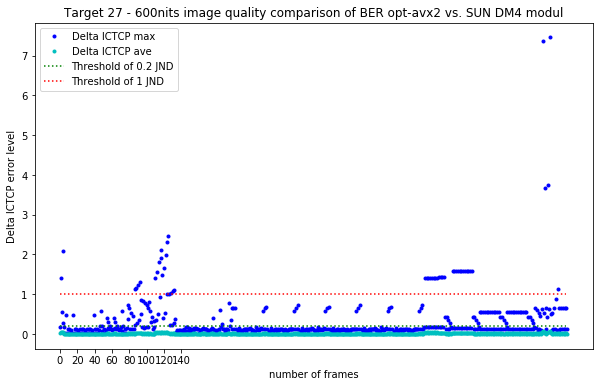

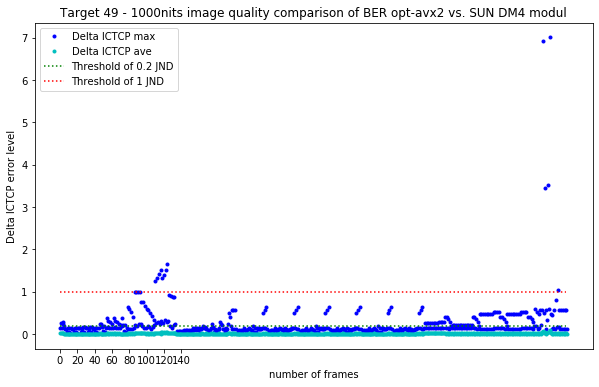

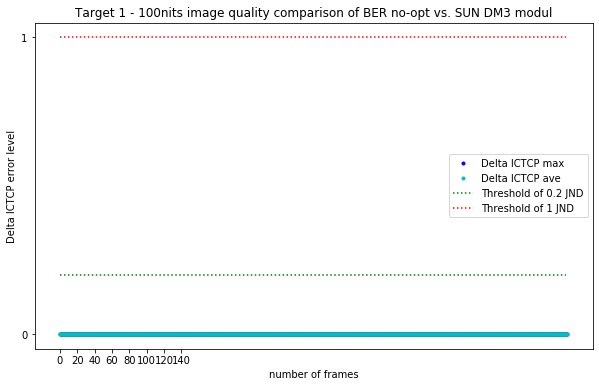

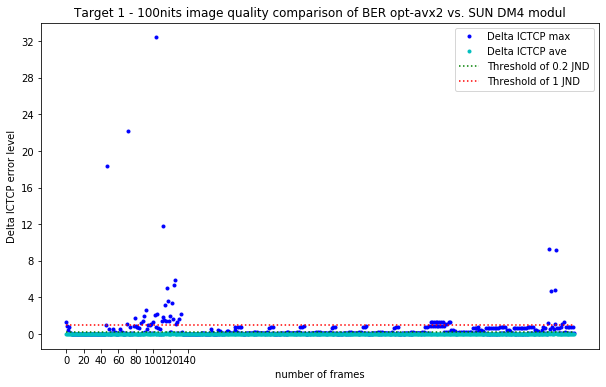

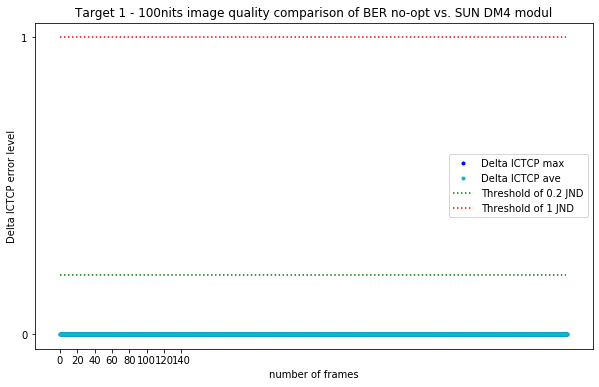

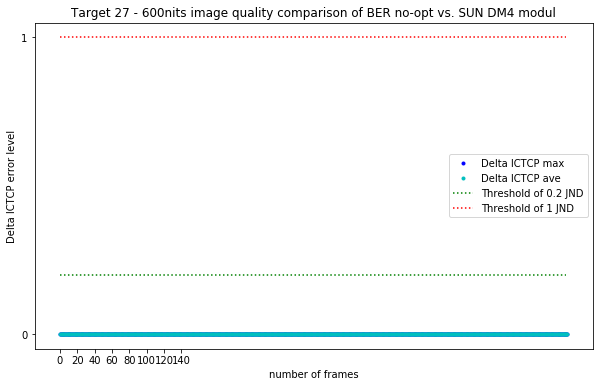

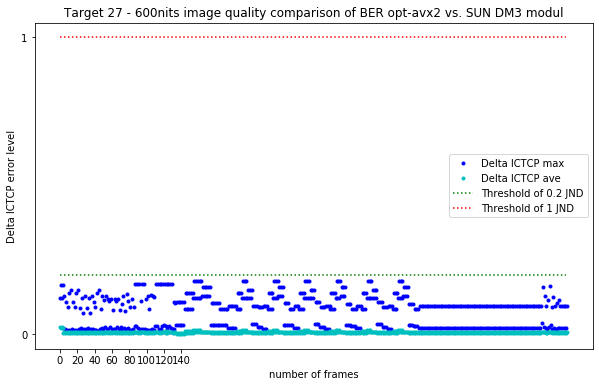

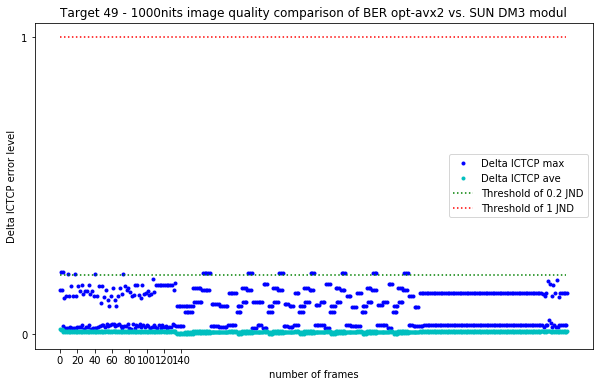

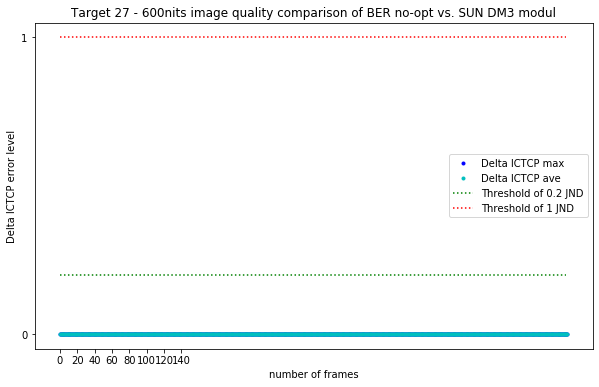

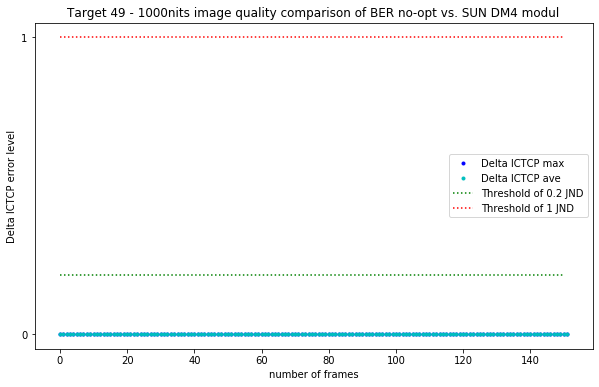

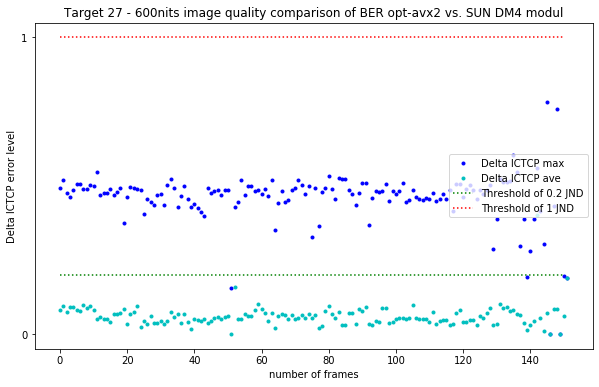

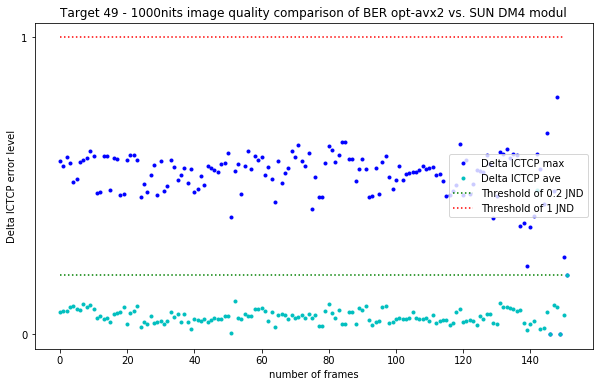

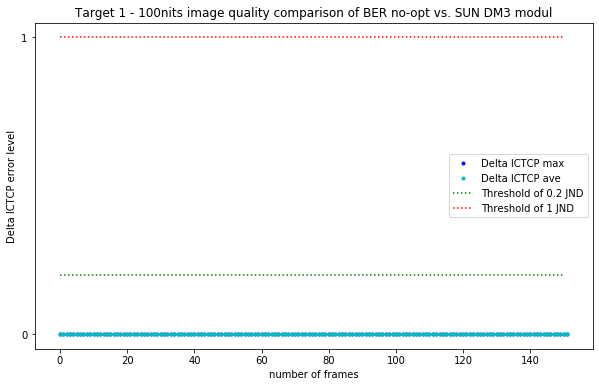

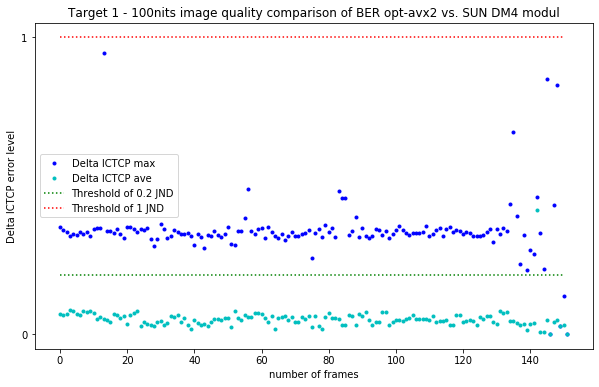

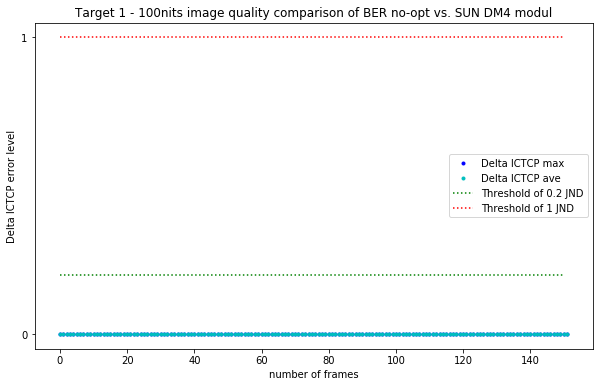

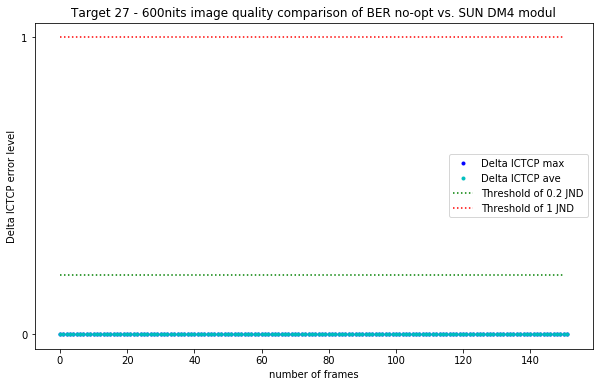

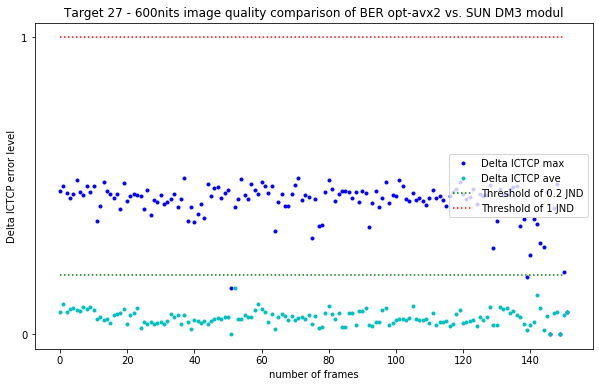

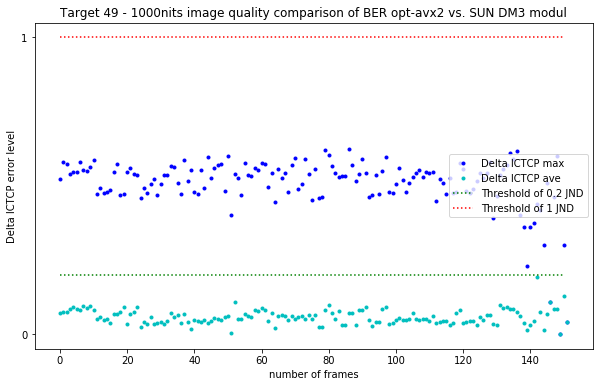

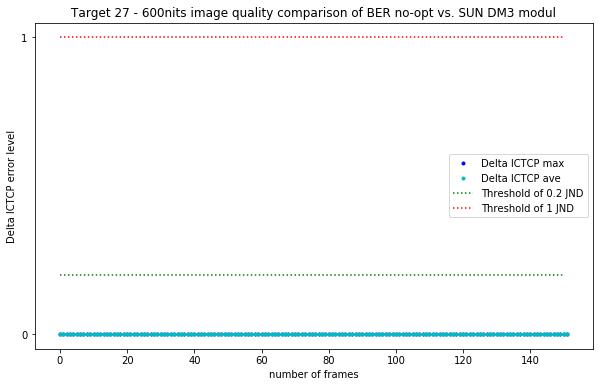

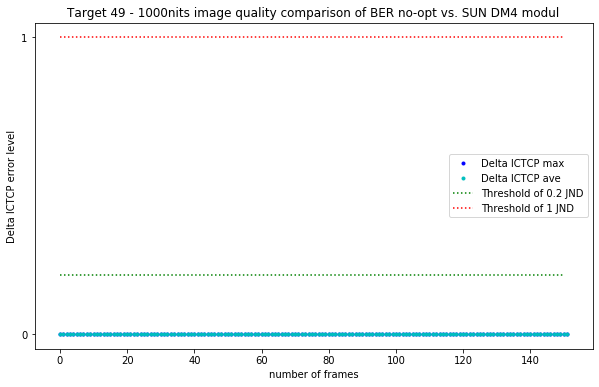

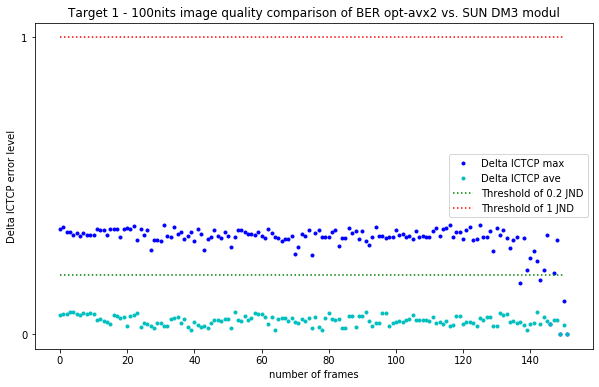

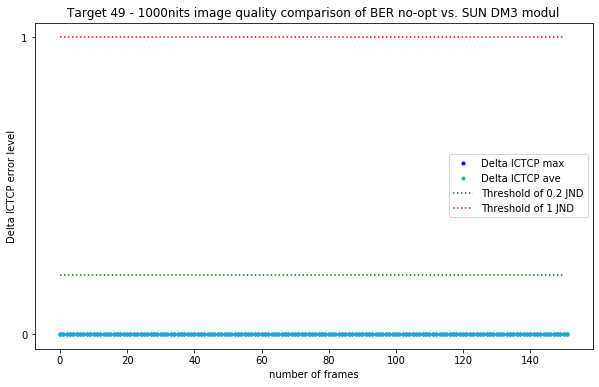

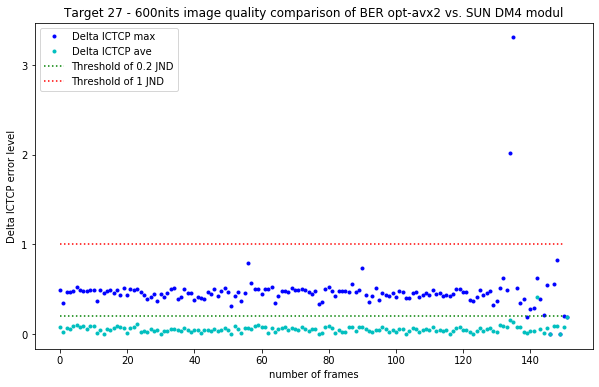

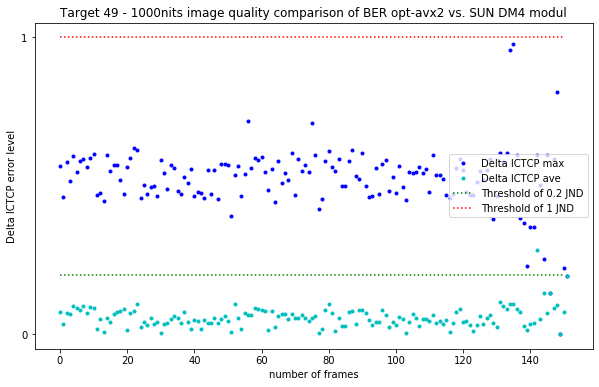

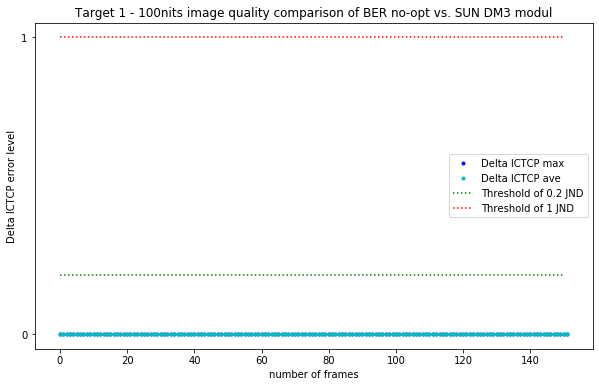

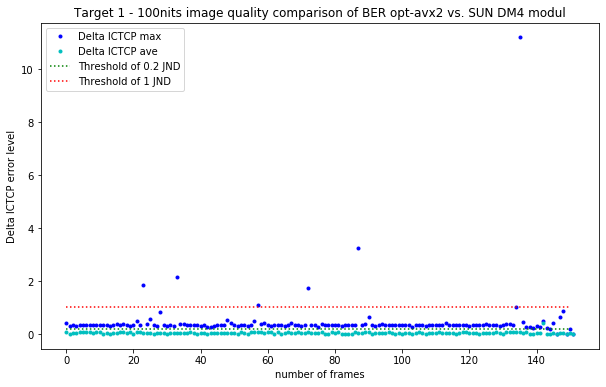

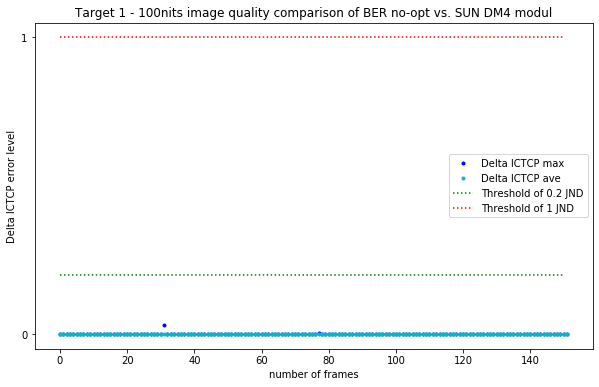

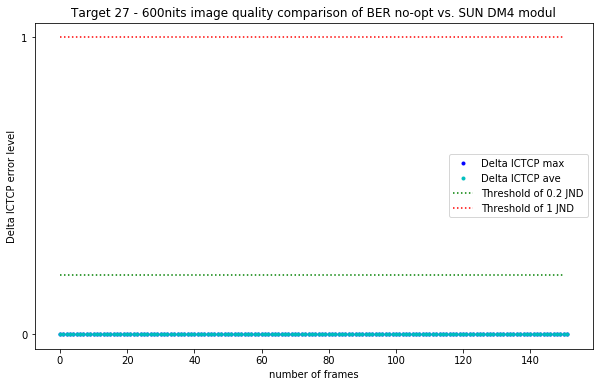

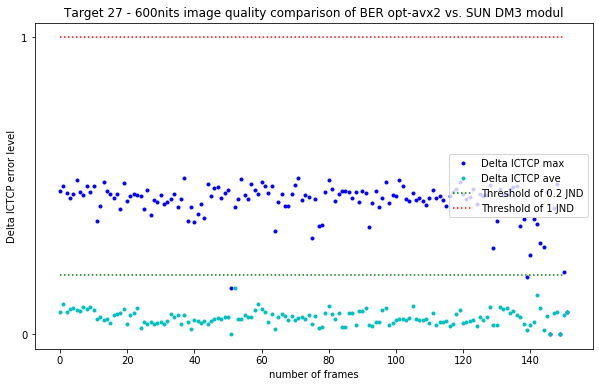

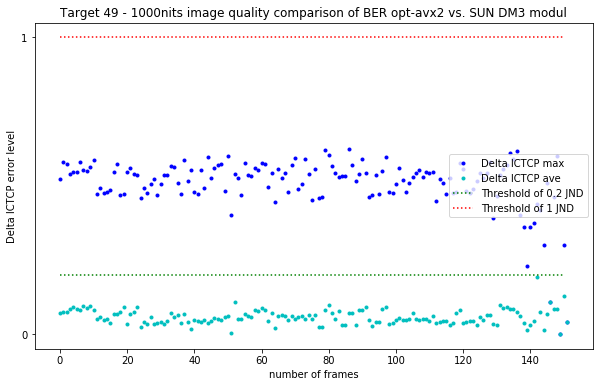

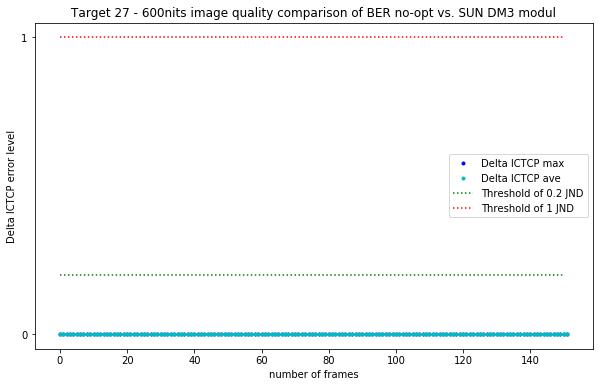

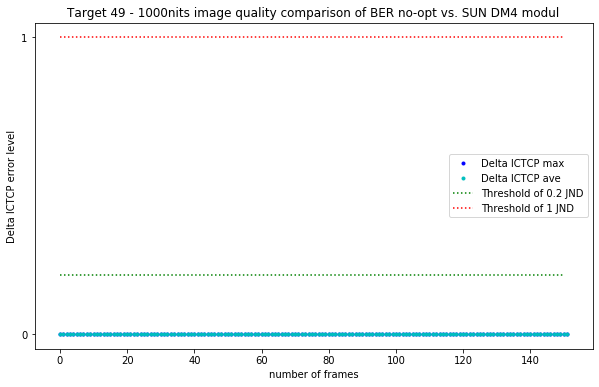

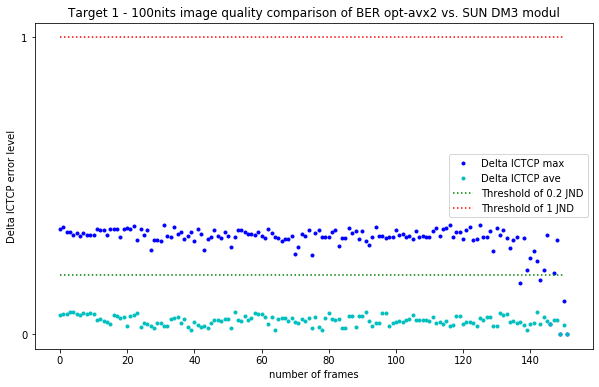

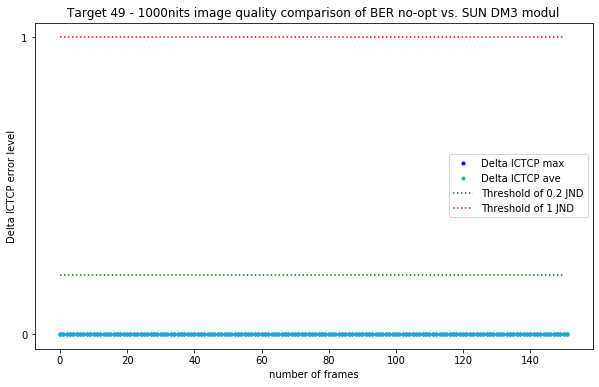

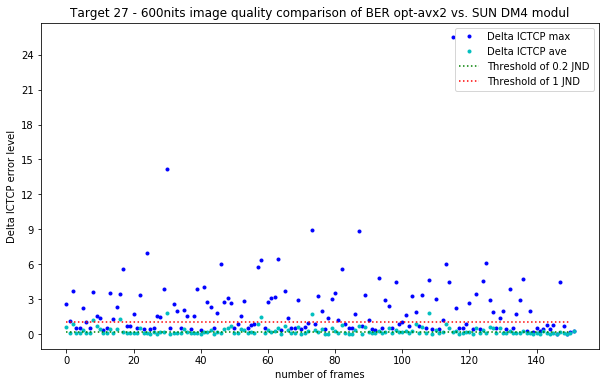

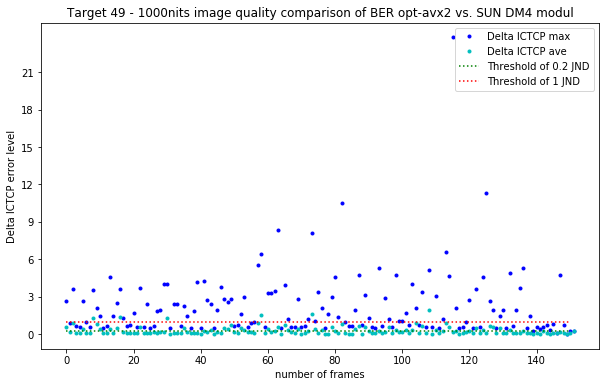

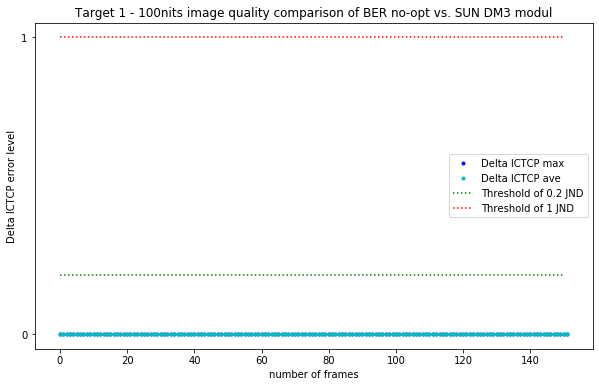

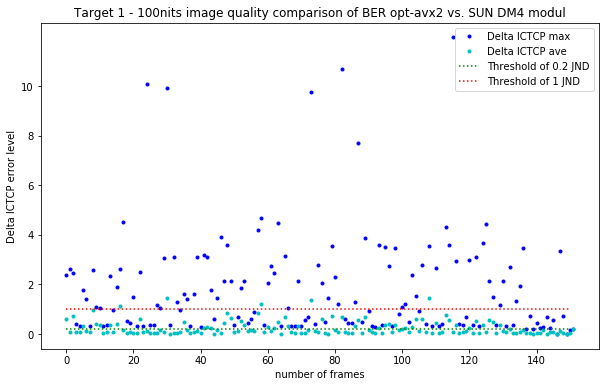

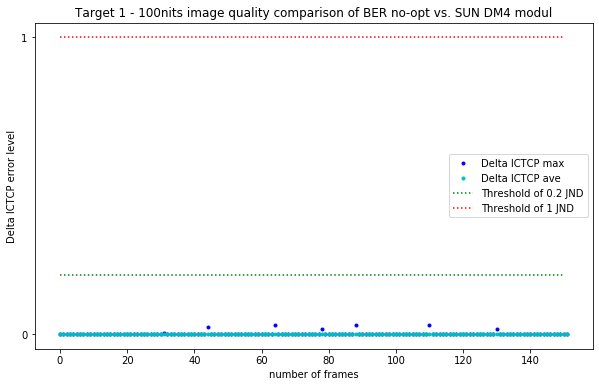

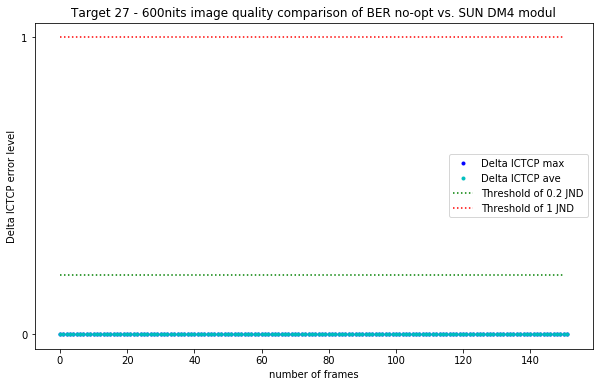

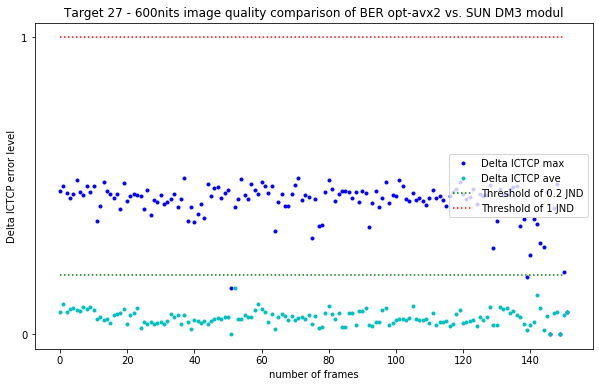

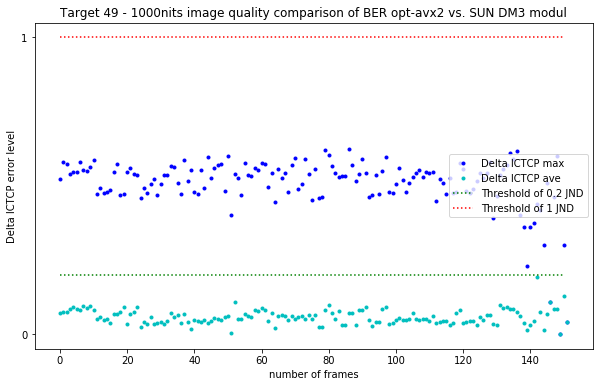

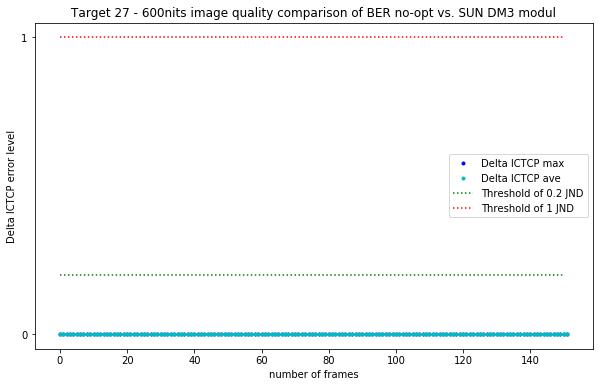

In [170]:
for case in cases_path:
    cases_content = glob.glob(case + "/*.*")
    full_paths = [p.split("/") for p in cases_content]
    files = [p.pop(-1) for p in full_paths]
    outpath = "/Users/hquos/Projects/DSV_libdm4/plots/" + case.split("/")[-1] + "/"
    try:
        os.mkdir(outpath) 
    except OSError as error: 
        print(error)
    print("Processing --> " + case.split("/")[-1])
    for file in files:
        df_log = draw_ictcp(file, case+"/", outpath)

## ToDo:
* write df in csv file for processing in Jenkins
* or only export max ICtCp value for threshold trigger
* add frames nr indication for max JND error value
* change Thresholds to dotted line
* change data representation to dots, not line, for better visibility